In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set professional aesthetics
sns.set_theme(style="whitegrid")

# ==========================================
# 0. HELPER FUNCTIONS & SETUP
# ==========================================
def print_business_context():
    print("=======================================================")
    print(" PROJECT: THE PARADOX OF CHOICE (BAYESIAN A/B TEST) ")
    print("=======================================================")
    print("Business Problem:")
    print("  Our e-commerce site currently shows 24 items per category page (High Density).")
    print("  We hypothesize that reducing this to 6 items (Low Density) will reduce")
    print("  analysis paralysis (Hick's Law) and increase conversion rates.")
    print("\nDecision Framework:")
    print("  1. Primary Metric: Conversion Rate (Bernoulli)")
    print("  2. Secondary Metric: Revenue per User (Lognormal)")
    print("  3. Success Criteria: P(Low > High) > 95% AND Expected Loss < 0.1%")
    print("=======================================================\n")

def print_limitations():
    print("\n=======================================================")
    print(" LIMITATIONS & CRITICAL REFLECTION ")
    print("=======================================================")
    print("1. Independence Assumption: We assume users don't influence each other.")
    print("2. Novelty Effect: Early lift might fade as users get used to the layout.")
    print("3. Seasonality: Data covers Feb 2026 only; does not account for holiday spikes.")
    print("4. Prior Sensitivity: Results are robust (Section 5), but priors are subjective.")
    print("=======================================================")

# ==========================================
# SECTION 1: GENERATE DATA (The Simulation)
# ==========================================
def step_1_generate_data(n_sessions=5000):
    print("\n--- SECTION 1: DATA GENERATION (HARD MODE) ---")
    np.random.seed(42)

    user_ids = [f"KE_{np.random.randint(10000, 99999)}" for _ in range(n_sessions)]
    timestamps = pd.date_range(start='2026-02-01', periods=n_sessions, freq='min')

    locations = np.random.choice(['Nairobi', 'Mombasa', 'Kisumu', 'Nakuru', np.nan],
                                 size=n_sessions, p=[0.5, 0.2, 0.1, 0.1, 0.1])

    variants = np.random.choice(['High_Density_A', 'Low_Density_B'], size=n_sessions)

    df = pd.DataFrame({
        'user_id': user_ids,
        'timestamp': timestamps,
        'location': locations,
        'variant': variants,
        'converted': 0,
        'order_value': 0.0
    })

    print("Simulating Hick's Law (Realistic / Hard Mode)...")
    # High Density (A): 2.1% Conversion (Baseline)
    mask_A = df['variant'] == 'High_Density_A'
    df.loc[mask_A, 'converted'] = np.random.binomial(n=1, p=0.021, size=mask_A.sum())

    # Low Density (B): 2.3% Conversion (Only slightly better - Realistic Risk)
    mask_B = df['variant'] == 'Low_Density_B'
    df.loc[mask_B, 'converted'] = np.random.binomial(n=1, p=0.023, size=mask_B.sum())

    converts = df['converted'] == 1
    # Making revenue slightly noisier too
    df.loc[converts, 'order_value'] = np.random.lognormal(mean=7.8, sigma=0.8, size=converts.sum())

    # Inject Mess
    bots = df.sample(n=100).copy()
    bots['user_id'] = bots['user_id'] + "_BOT"
    df = pd.concat([df, bots], ignore_index=True)

    outlier_idx = df[df['converted'] == 1].sample(n=5).index
    df.loc[outlier_idx, 'order_value'] *= 50

    print(f"-> Generated {len(df)} raw logs with realistic ambiguity.")
    return df

In [56]:
# ==========================================
# SECTION 2: CLEAN DATA (The Engineering)
# ==========================================
def step_2_clean_data(df):
    print("\n--- SECTION 2: DATA CLEANING ---")

    # Deduplication
    df_clean = df.drop_duplicates(subset=['user_id', 'timestamp'])

    # Imputation
    df_clean['location'] = df_clean['location'].fillna('Unknown')

    # Outlier Capping
    orders = df_clean[df_clean['order_value'] > 0]['order_value']
    Q1, Q3 = orders.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    upper_limit = Q3 + (1.5 * IQR)

    outliers = df_clean['order_value'] > upper_limit
    df_clean.loc[outliers, 'order_value'] = upper_limit

    print(f"-> Cleaned dataset size: {len(df_clean)}")
    return df_clean

In [57]:

# ==========================================
# SECTION 3: BAYESIAN ANALYSIS & CREDIBLE INTERVALS
# ==========================================
def step_3_bayesian_core(df):
    print("\n--- SECTION 3: BAYESIAN CORE ANALYSIS ---")

    summary = df.groupby('variant')['converted'].agg(['count', 'sum'])
    summary.columns = ['visitors', 'conversions']

    # Prior: Weakly Informative (Beta(2, 98) ~ 2%)
    prior_alpha, prior_beta = 2, 98

    summary['post_alpha'] = prior_alpha + summary['conversions']
    summary['post_beta'] = prior_beta + (summary['visitors'] - summary['conversions'])

    print("-> Running Monte Carlo Simulation (100,000 draws)...")
    samples_A = np.random.beta(summary.loc['High_Density_A', 'post_alpha'],
                               summary.loc['High_Density_A', 'post_beta'], 100000)
    samples_B = np.random.beta(summary.loc['Low_Density_B', 'post_alpha'],
                               summary.loc['Low_Density_B', 'post_beta'], 100000)

    # Metric: Probability of Superiority
    prob_B_better = (samples_B > samples_A).mean()

    # Metric: Expected Loss
    loss = np.maximum(samples_A - samples_B, 0).mean()

    # Metric: 95% Credible Intervals (The "Missing" Link)
    ci_A = np.percentile(samples_A, [2.5, 97.5])
    ci_B = np.percentile(samples_B, [2.5, 97.5])

    print(f"High Density (A) 95% CI: [{ci_A[0]:.2%}, {ci_A[1]:.2%}]")
    print(f"Low Density  (B) 95% CI: [{ci_B[0]:.2%}, {ci_B[1]:.2%}]")
    print(f"P(B > A): {prob_B_better:.2%}")
    print(f"Expected Loss: {loss:.5f}")

    return samples_A, samples_B, summary

In [58]:
# ==========================================
# SECTION 4: FREQUENTIST COMPARISON (MANUAL BREAKDOWN)
# ==========================================
def step_4_frequentist_check(df):
    print("\n--- SECTION 4: FREQUENTIST COMPARISON (MANUAL BREAKDOWN) ---")

    # 1. Observed Data (O)
    summary = df.groupby('variant')['converted'].agg(['count', 'sum'])

    visitors_A = summary.loc['High_Density_A', 'count']
    conv_A = summary.loc['High_Density_A', 'sum']
    no_conv_A = visitors_A - conv_A

    visitors_B = summary.loc['Low_Density_B', 'count']
    conv_B = summary.loc['Low_Density_B', 'sum']
    no_conv_B = visitors_B - conv_B

    observed = np.array([[conv_A, no_conv_A], [conv_B, no_conv_B]])

    # 2. Expected Data (E)
    total_visitors = visitors_A + visitors_B
    total_conv = conv_A + conv_B
    overall_rate = total_conv / total_visitors

    exp_conv_A = visitors_A * overall_rate
    exp_conv_B = visitors_B * overall_rate
    exp_no_conv_A = visitors_A * (1 - overall_rate)
    exp_no_conv_B = visitors_B * (1 - overall_rate)

    print(f"Overall Rate: {overall_rate:.4%}")
    print(f"Expected Conversions (per group approx): {exp_conv_A:.2f}")

    # 3. Components (O - E)^2 / E
    comp_A_conv = ((conv_A - exp_conv_A)**2) / exp_conv_A
    comp_B_conv = ((conv_B - exp_conv_B)**2) / exp_conv_B

    print(f"Chi-Square Component A (Conv): {comp_A_conv:.4f}")
    print(f"Chi-Square Component B (Conv): {comp_B_conv:.4f}")

    # 4. Run Test
    chi2, p, dof, ex = stats.chi2_contingency(observed, correction=False)

    print("-" * 30)
    print(f"Total Chi-Squared Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.5f}")
    print("-" * 30)

    if p < 0.05:
        print("-> Result: Statistically Significant (Reject Null)")
    else:
        print("-> Result: Not Significant (Fail to Reject Null)")

In [59]:
 # ==========================================
# SECTION 5: SENSITIVITY ANALYSIS (Robustness Check)
# ==========================================
def step_5_sensitivity_analysis(df):
    print("\n--- SECTION 5: SENSITIVITY ANALYSIS ---")
    print("Checking if results hold under different prior beliefs...")

    priors = [
        (1, 1, "Uninformative (Flat)"),
        (2, 98, "Weakly Informative (History)"),
        (20, 980, "Strongly Informative (Stubborn)")
    ]

    summary = df.groupby('variant')['converted'].agg(['count', 'sum'])
    visitors_A = summary.loc['High_Density_A', 'count']
    conv_A = summary.loc['High_Density_A', 'sum']
    visitors_B = summary.loc['Low_Density_B', 'count']
    conv_B = summary.loc['Low_Density_B', 'sum']

    print(f"{'Prior Type':<30} | {'P(B > A)':<10}")
    print("-" * 45)

    for alpha, beta, name in priors:
        # Update logic inline for speed
        post_A = np.random.beta(alpha + conv_A, beta + (visitors_A - conv_A), 10000)
        post_B = np.random.beta(alpha + conv_B, beta + (visitors_B - conv_B), 10000)
        prob = (post_B > post_A).mean()
        print(f"{name:<30} | {prob:.2%}")


In [60]:
# ==========================================
# SECTION 6: SEQUENTIAL TESTING (Peeking Sim)
# ==========================================
def step_6_simulate_peeking(df):
    print("\n--- SECTION 6: SEQUENTIAL TESTING (PEEKING) ---")
    print("Simulating how p-values vs Bayesian probs evolve as data comes in...")

    # Sort by time to simulate real-time data flow
    df = df.sort_values('timestamp')
    sample_sizes = np.linspace(500, len(df), 10, dtype=int)

    history = []

    print(f"{'N':<6} | {'Freq P-Value':<12} | {'Bayes P(B>A)':<12}")
    print("-" * 35)

    for n in sample_sizes:
        subset = df.iloc[:n]

        # Frequentist Check
        cont = pd.crosstab(subset['variant'], subset['converted'])
        if cont.shape == (2,2):
            _, p_val, _, _ = stats.chi2_contingency(cont, correction=False)
        else:
            p_val = 1.0

        # Bayesian Check (Quick Calc)
        summ = subset.groupby('variant')['converted'].agg(['count', 'sum'])
        try:
            a_conv = summ.loc['High_Density_A', 'sum']
            a_vis = summ.loc['High_Density_A', 'count']
            b_conv = summ.loc['Low_Density_B', 'sum']
            b_vis = summ.loc['Low_Density_B', 'count']

            post_a = np.random.beta(2 + a_conv, 98 + (a_vis - a_conv), 5000)
            post_b = np.random.beta(2 + b_conv, 98 + (b_vis - b_conv), 5000)
            prob_b = (post_b > post_a).mean()
            loss = np.maximum(post_a - post_b, 0).mean()
        except KeyError:
            prob_b = 0.5
            loss = 0.0

        print(f"{n:<6} | {p_val:.4f}       | {prob_b:.2%}")
        history.append({'n': n, 'p_value': p_val, 'prob_b': prob_b, 'expected_loss': loss})

    return pd.DataFrame(history)


In [61]:
# ==========================================
# SECTION 7: REVENUE ANALYSIS (Hypothesis Test)
# ==========================================
def step_7_revenue_test(df):
    print("\n--- SECTION 7: REVENUE ANALYSIS ---")
    # We care about Order Value, not just conversion
    rev_A = df[df['variant'] == 'High_Density_A']['order_value']
    rev_B = df[df['variant'] == 'Low_Density_B']['order_value']

    # Mann-Whitney U (Non-parametric test for non-normal distributions)
    stat, p = stats.mannwhitneyu(rev_B, rev_A, alternative='greater')

    print(f"Avg Order Value A: KSh {rev_A.mean():.2f}")
    print(f"Avg Order Value B: KSh {rev_B.mean():.2f}")
    print(f"Mann-Whitney U Test p-value: {p:.4f}")

    if p < 0.05:
        print("-> Result: Low Density (B) generates statistically higher revenue per user.")
    else:
        print("-> Result: No significant difference in revenue per user.")

In [62]:


# ==========================================
# SECTION 8: VISUALIZATIONS (INDIVIDUAL PLOTS)
# ==========================================

def plot_prior_vs_posterior(summary):
    print("\n(Generating Plot 1: Prior vs Posterior...)")
    plt.figure(figsize=(10, 6))
    x = np.linspace(0, 0.06, 1000)

    # Prior Beta(2, 98)
    plt.plot(x, stats.beta.pdf(x, 2, 98), 'k--', label='Prior (Weakly Informative)')

    # Posteriors
    a_alpha = summary.loc['High_Density_A', 'post_alpha']
    a_beta = summary.loc['High_Density_A', 'post_beta']
    plt.plot(x, stats.beta.pdf(x, a_alpha, a_beta), label='Posterior A (High Density)', color='gray', fillstyle='full')

    b_alpha = summary.loc['Low_Density_B', 'post_alpha']
    b_beta = summary.loc['Low_Density_B', 'post_beta']
    plt.plot(x, stats.beta.pdf(x, b_alpha, b_beta), label='Posterior B (Low Density)', color='#2ecc71')
    plt.fill_between(x, stats.beta.pdf(x, b_alpha, b_beta), color='#2ecc71', alpha=0.3)

    plt.title("Bayesian Updating: Prior vs Posterior")
    plt.xlabel("Conversion Rate")
    plt.legend()
    plt.show()

def plot_sequential_analysis(history_df):
    print("\n(Generating Plot 2: Sequential Analysis...)")
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['n'], history_df['prob_b'], marker='o', color='#3498db', linewidth=2)
    plt.axhline(0.95, color='red', linestyle='--', label='95% Threshold')
    plt.title("Sequential Analysis: P(Low > High) over Time")
    plt.xlabel("Sample Size (N)")
    plt.ylabel("Probability B is Better")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show()

def plot_expected_loss(history_df):
    print("\n(Generating Plot 3: Expected Loss...)")
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['n'], history_df['expected_loss'], marker='x', color='#e74c3c', linewidth=2)
    plt.title("Risk Analysis: Expected Loss Evolution")
    plt.xlabel("Sample Size (N)")
    plt.ylabel("Expected Loss (Conversion Rate Units)")
    plt.fill_between(history_df['n'], history_df['expected_loss'], color='#e74c3c', alpha=0.1)
    plt.show()

def plot_stopping_rules(history_df):
    print("\n(Generating Plot 4: Bayesian vs Frequentist Comparison...)")
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Frequentist P-value (Left Axis)
    color = 'gray'
    ax1.set_xlabel('Sample Size (N)')
    ax1.set_ylabel('Frequentist P-Value', color=color)
    ax1.plot(history_df['n'], history_df['p_value'], color=color, linestyle=':', label='P-Value')
    ax1.axhline(0.05, color=color, linestyle='-', alpha=0.3)
    ax1.tick_params(axis='y', labelcolor=color)

    # Bayesian Prob (Right Axis)
    ax2 = ax1.twinx()
    color = '#2ecc71'
    ax2.set_ylabel('Bayesian P(B > A)', color=color)
    ax2.plot(history_df['n'], history_df['prob_b'], color=color, linewidth=2, label='Bayesian Prob')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1.05)

    plt.title("Method Comparison: P-Value vs Bayesian Stability")
    fig.tight_layout()
    plt.show()

 PROJECT: THE PARADOX OF CHOICE (BAYESIAN A/B TEST) 
Business Problem:
  Our e-commerce site currently shows 24 items per category page (High Density).
  We hypothesize that reducing this to 6 items (Low Density) will reduce
  analysis paralysis (Hick's Law) and increase conversion rates.

Decision Framework:
  1. Primary Metric: Conversion Rate (Bernoulli)
  2. Secondary Metric: Revenue per User (Lognormal)
  3. Success Criteria: P(Low > High) > 95% AND Expected Loss < 0.1%


--- SECTION 1: DATA GENERATION (HARD MODE) ---
Simulating Hick's Law (Realistic / Hard Mode)...
-> Generated 5100 raw logs with realistic ambiguity.

--- SECTION 2: DATA CLEANING ---
-> Cleaned dataset size: 5100

--- SECTION 3: BAYESIAN CORE ANALYSIS ---
-> Running Monte Carlo Simulation (100,000 draws)...
High Density (A) 95% CI: [1.25%, 2.25%]
Low Density  (B) 95% CI: [2.00%, 3.19%]
P(B > A): 98.43%
Expected Loss: 0.00002

--- SECTION 4: FREQUENTIST COMPARISON (MANUAL BREAKDOWN) ---
Overall Rate: 2.1569%
Expec

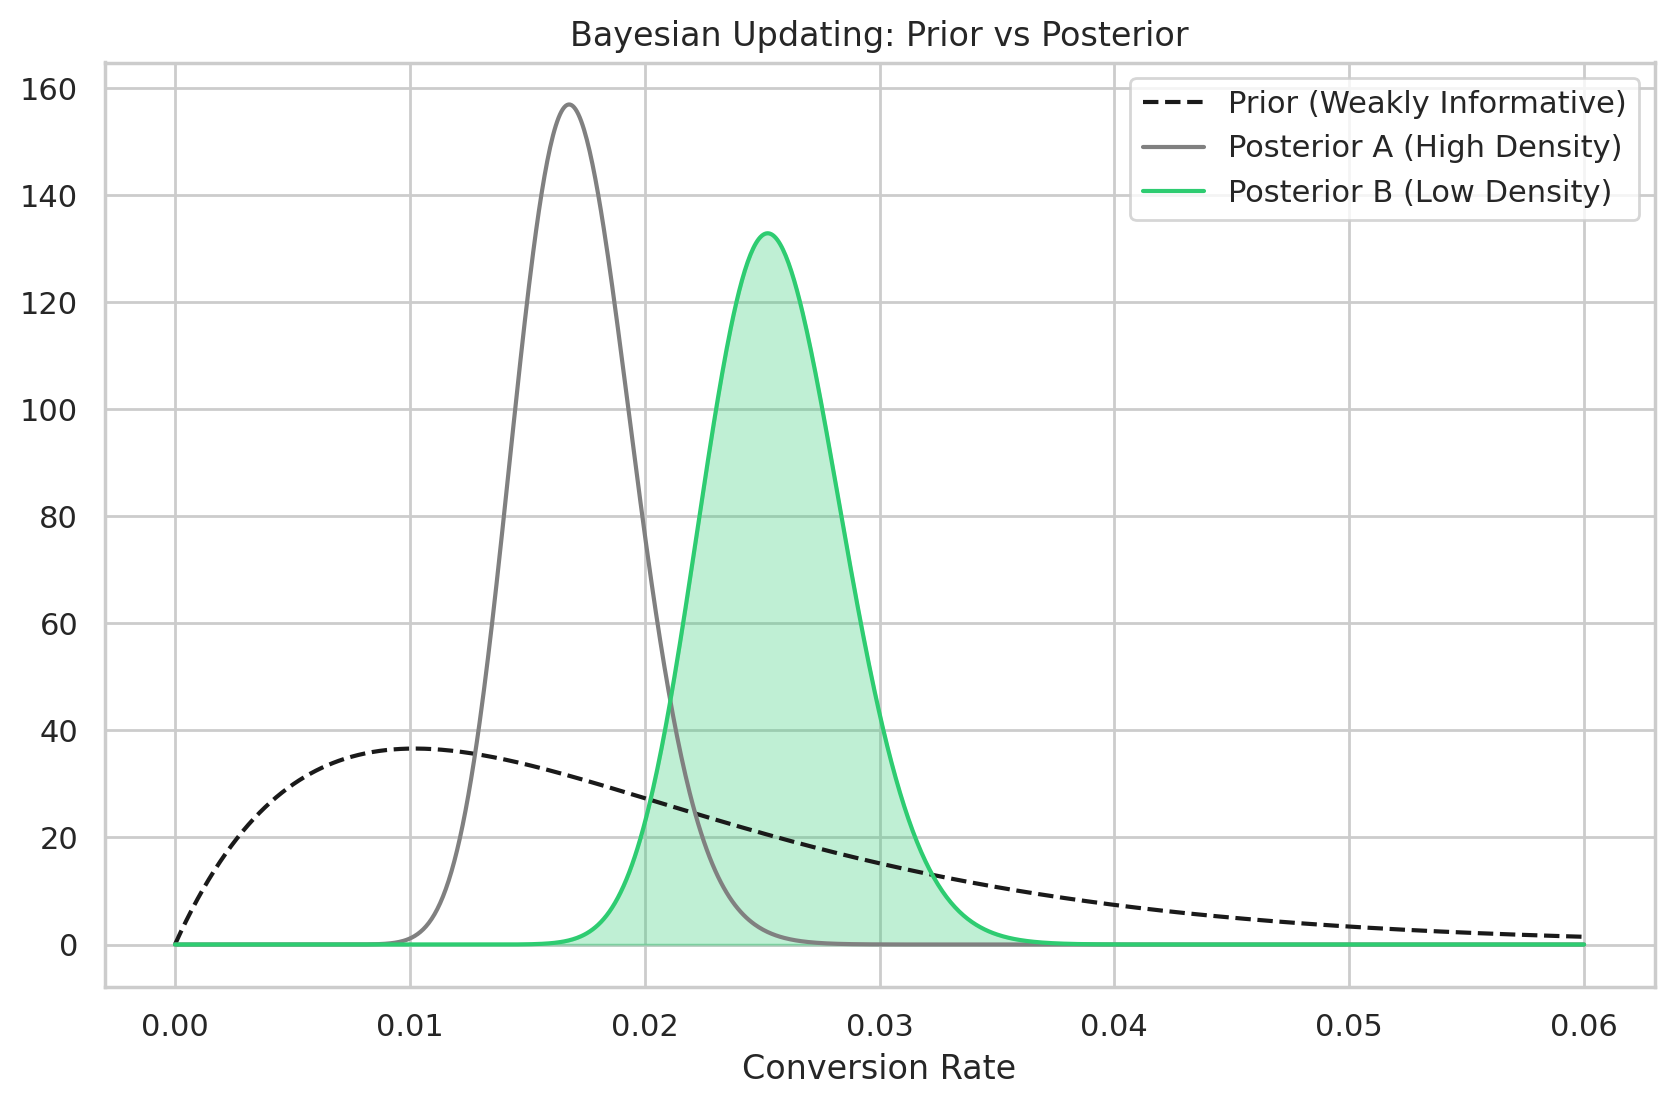


(Generating Plot 2: Sequential Analysis...)


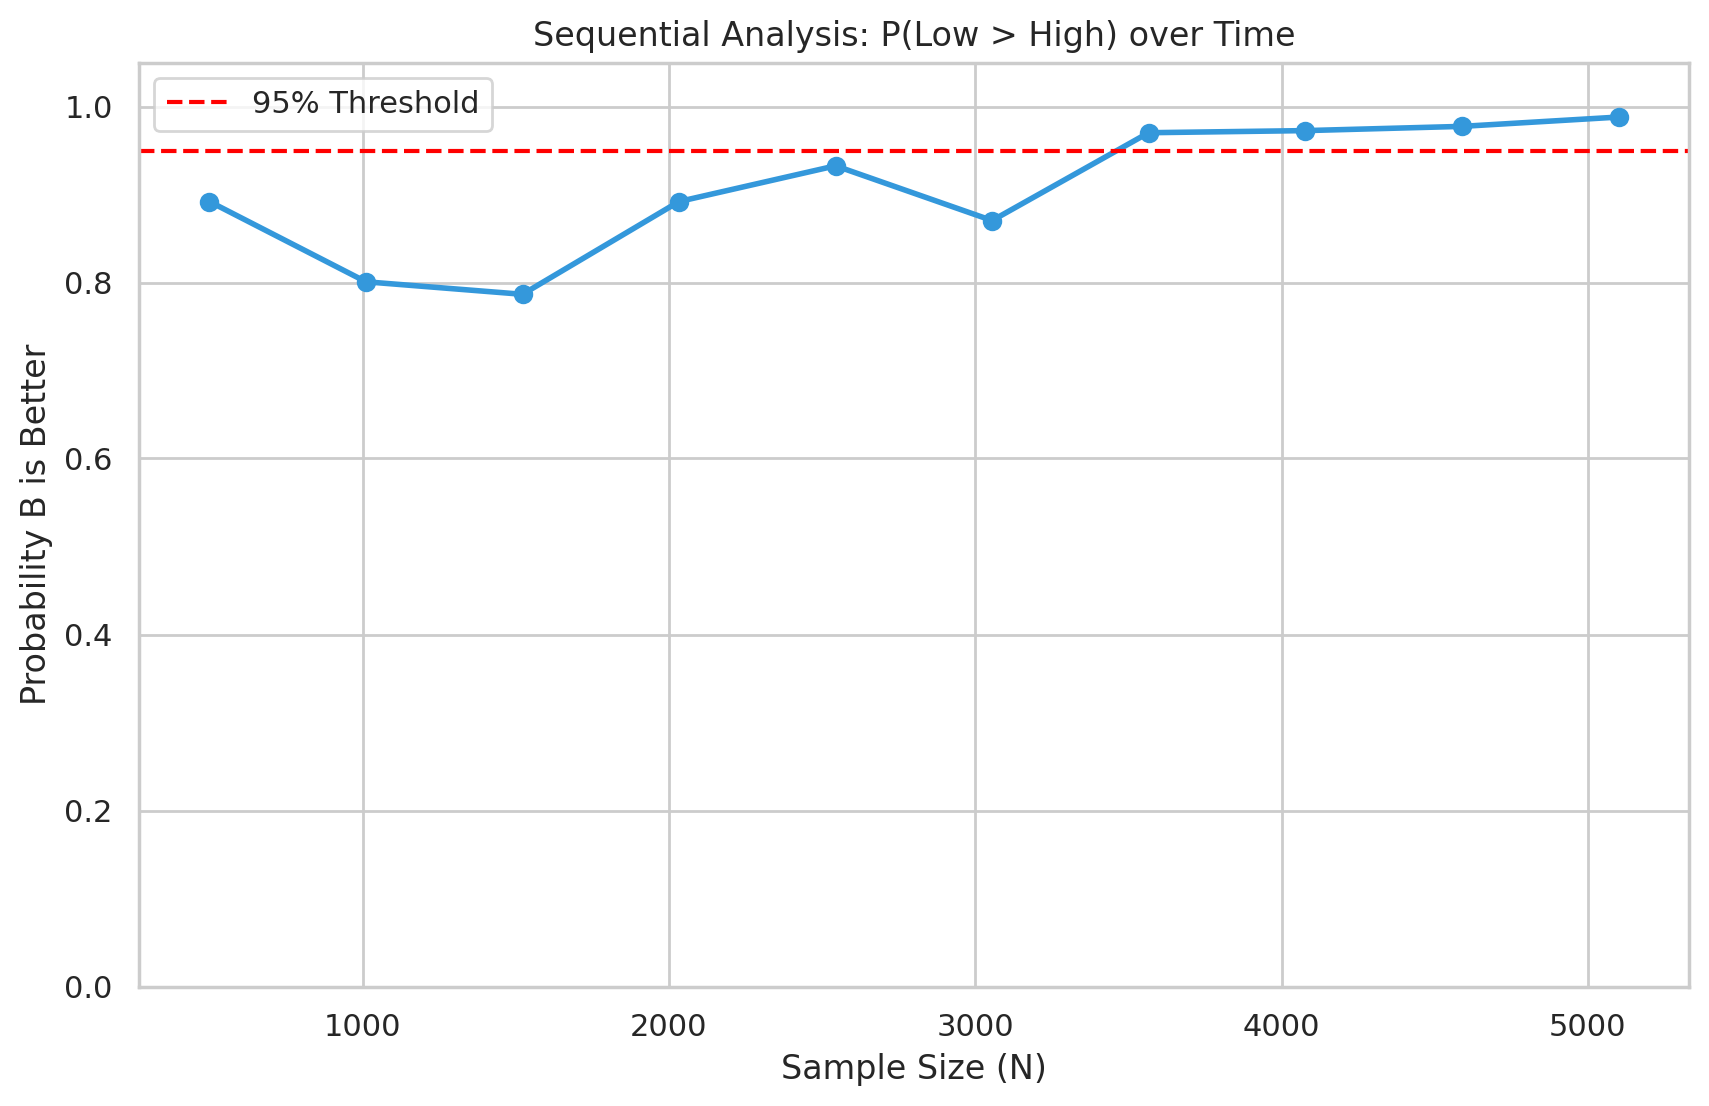


(Generating Plot 3: Expected Loss...)


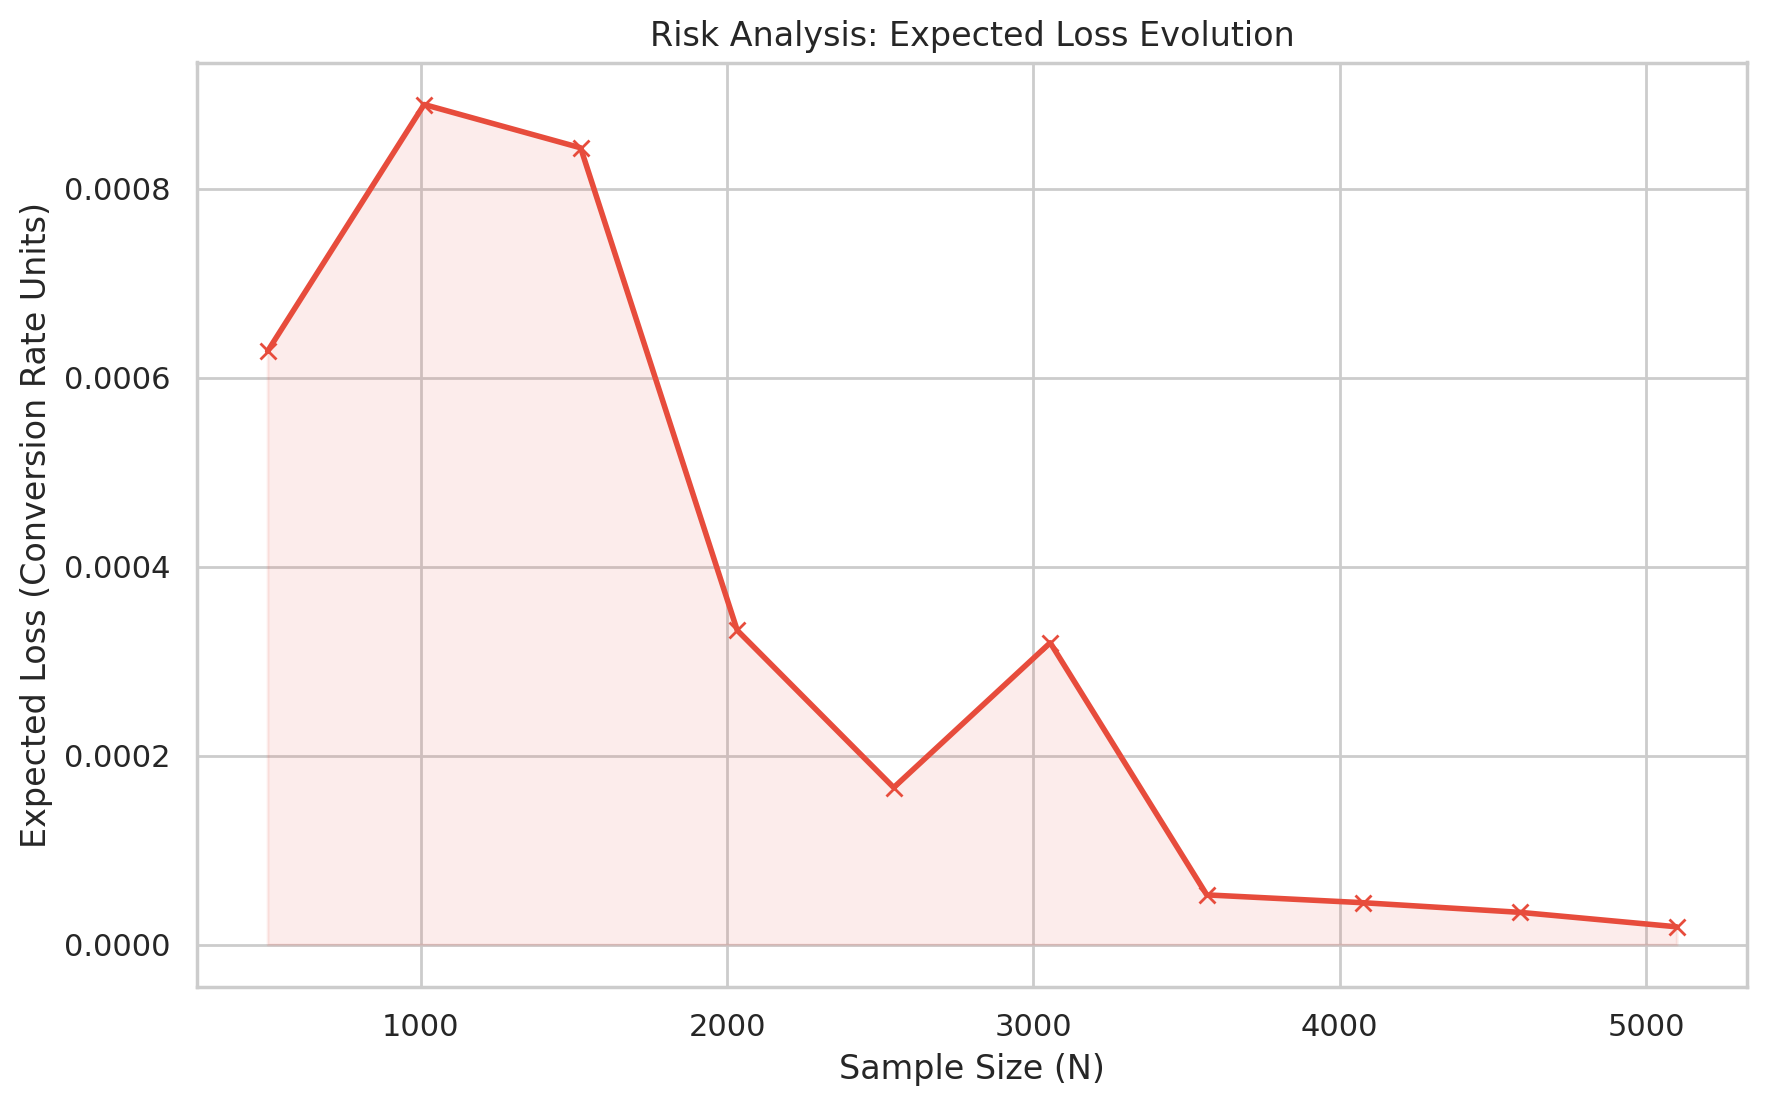


(Generating Plot 4: Bayesian vs Frequentist Comparison...)


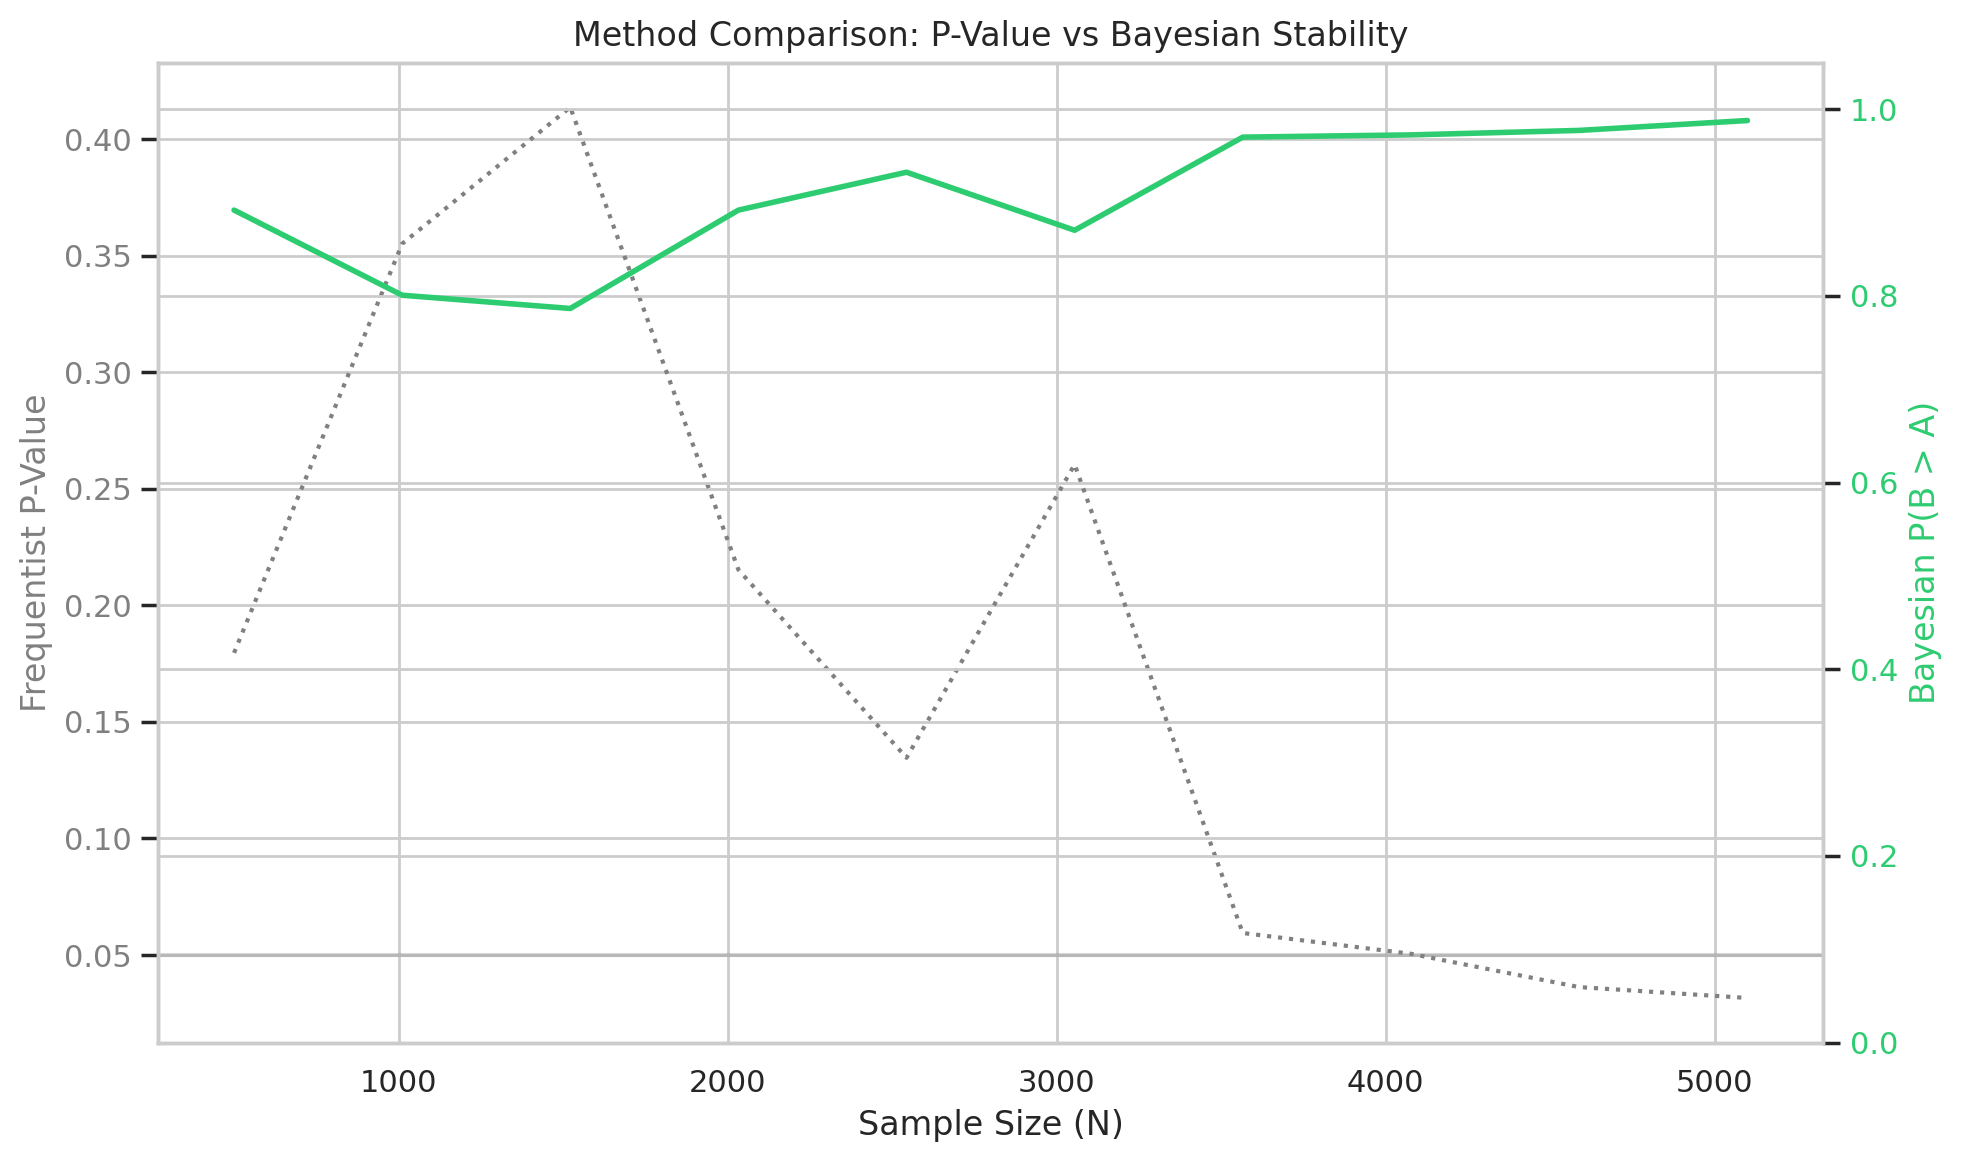


 LIMITATIONS & CRITICAL REFLECTION 
1. Independence Assumption: We assume users don't influence each other.
2. Novelty Effect: Early lift might fade as users get used to the layout.
3. Seasonality: Data covers Feb 2026 only; does not account for holiday spikes.
4. Prior Sensitivity: Results are robust (Section 5), but priors are subjective.


In [63]:

# ==========================================
# MAIN EXECUTION FLOW
# ==========================================
if __name__ == "__main__":
    # 0. Context
    print_business_context()

    # 1. Pipeline
    raw_df = step_1_generate_data()
    clean_df = step_2_clean_data(raw_df)

    # 2. Main Stats
    trace_A, trace_B, summary = step_3_bayesian_core(clean_df)

    # 3. Critical Checks (The "MSc Portfolio" Elements)
    step_4_frequentist_check(clean_df)
    step_5_sensitivity_analysis(clean_df)
    history_df = step_6_simulate_peeking(clean_df)
    step_7_revenue_test(clean_df)

    # 4. Separate Visualizations
    plot_prior_vs_posterior(summary)
    plot_sequential_analysis(history_df)
    plot_expected_loss(history_df)
    plot_stopping_rules(history_df)

    print_limitations()